**NOTES**
PROGRESS:
- Masih pre-processing & EDA
- Referensi jurnal http://reports-archive.adm.cs.cmu.edu/anon/isr2020/CMU-ISR-20-109.pdf Chapter 4
- Model yang akan digunakan K-Means/MVMC?

TODO:
- Bikin 1 tabel yang text nya di stemming
- Bikin 1 tabel yang text nya ga di stemming

## Modules

In [1]:
import ast
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

from tqdm import tqdm
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from datetime import datetime
from wordcloud import WordCloud
from collections import Counter

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\suppe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data

In [2]:
idata = pd.read_csv('./data/initial_data_REVISI.csv')
nddata = pd.read_csv('./data/data_non_duplicate_tweets_REVISI.csv')
idata['created_at'] = idata['created_at'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M:%S'))
nddata['created_at'] = nddata['created_at'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M:%S'))

In [3]:
len(idata), len(nddata)

(311625, 98743)

In [4]:
# only tweets with hashtags
tweets_hashtags = pd.DataFrame(nddata[nddata.hashtags.notnull()]).reset_index(drop=True)

In [5]:
len(tweets_hashtags)

11867

In [6]:
tweets_hashtags.head(2)

,text,hashtags,created_at,reference_type,lang,users.username,users.following,users.tweets,users.location,users.verified,metrics.retweets,metrics.replies,metrics.quotes,metrics.impressions,entities.mentions,entities.url title,places.name,places.place_type,places.country,places.country_code
0,banding ukt turunnya gaji hingga phk banyak di...,"['himitpens', 'kabinetagnibrata', 'forzainform...",2022-01-01 14:03:02,NaN,in,himitpens,156.0,4960.0,Surabaya,False,0,1,0,0,[],[],NaN,NaN,NaN,NaN
1,ada suara kemarin tentang pembubaran nasib phk...,['brin'],2022-01-02 08:00:54,['quoted'],in,dir1ku,3254.0,65752.0,Malang,False,1,0,0,0,['brin_indonesia'],[],NaN,NaN,NaN,NaN


## Preprocessing II

Removing hashtags that are not used in at least 3 tweets

In [7]:
all_hashtags = []

for ihashtag in nddata['hashtags']:
    if ihashtag is not np.nan:
        for item in ast.literal_eval(ihashtag):
            all_hashtags.append(item)
    else:
        continue

In [8]:
all_hashtags_counter = dict(Counter(all_hashtags))
removed_hashtags = list({k:v for k, v in all_hashtags_counter.items() if v <= 3}.keys())

In [9]:
def clean_hashtags(series, removed_hashtags):
    lists = []
    
    for hashtag in series:
        if hashtag is not np.nan:
            listshashtag = ast.literal_eval(hashtag)
            for item in listshashtag:
                if item in removed_hashtags:
                    listshashtag.remove(item)
                else:
                    continue
            if len(listshashtag) == 0:
                listshashtag = np.nan
                
            lists.append(listshashtag)
        else:
            lists.append(np.nan)
            
    return lists

In [10]:
idata['hashtags'] = clean_hashtags(idata['hashtags'], removed_hashtags)
nddata['hashtags'] = clean_hashtags(nddata['hashtags'], removed_hashtags)
tweets_hashtags['hashtags'] = clean_hashtags(tweets_hashtags['hashtags'], removed_hashtags)
tweets_hashtags = tweets_hashtags[tweets_hashtags.hashtags.notnull()].reset_index(drop=True)

In [11]:
tweets_hashtags.tail(2)

,text,hashtags,created_at,reference_type,lang,users.username,users.following,users.tweets,users.location,users.verified,metrics.retweets,metrics.replies,metrics.quotes,metrics.impressions,entities.mentions,entities.url title,places.name,places.place_type,places.country,places.country_code
10811,startup berbasis arisan online shox rumahan ba...,"[bisnisupdate, update, bisnis, oneliner]",2023-03-30 13:01:31,NaN,in,kumparan,3.0,953869.0,NaN,True,0,0,1,1963,[],[],NaN,NaN,NaN,NaN
10812,disney hapus divisi metaverse di putaran perta...,[tempotekno],2023-03-30 15:20:12,NaN,in,tempodotco,28.0,1163490.0,Indonesia,False,0,0,0,1475,[],['Disney Hapus Divisi Metaverse di Putaran Per...,NaN,NaN,NaN,NaN


In [12]:
idata.shape, nddata.shape, tweets_hashtags.shape

((311625, 20), (98743, 20), (10813, 20))

#### Replace Words

In [13]:
willreplace = json.load(open('./data/replaceword.json'))

In [14]:
words_replaced = []
for text in tweets_hashtags.text:
    tokenized = word_tokenize(text)
    
    items = []
    for item in tokenized:
        if item.startswith("bestie"):
            item = item.split("bestie")[1]
        if item.startswith("sob"):
            item = item.split("sob")[1]
        if item.startswith("sobat"):
            item = item.split("sobat")[1]
        if item.startswith("friends"):
            item = item.split("friends")[1]
        item.strip()
        if len(item) > 1:
            
            getword = willreplace.get(item, item)
            items.append(getword)
        
    words_replaced.append(' '.join(items))

In [15]:
tweets_hashtags.text = words_replaced

#### Removal of Stopwords

In [16]:
f = open("./data/tala-stopwords-indonesia.txt", "r")
stopword_list = []
for line in f:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    stopword_list.append(line_list[0])
f.close()

len(stopword_list)

806

In [17]:
stop_factory = StopWordRemoverFactory()

In [18]:
stopword_list += stop_factory.get_stop_words()

In [19]:
stopwords_removed = []
for text in tweets_hashtags.text:
    tokenized = word_tokenize(text)
    
    removed = ' '.join([word for word in tokenized if not word in stopword_list])
    
    stopwords_removed.append(removed)

In [20]:
tweets_hashtags.text = stopwords_removed
tweets_hashtags = tweets_hashtags.drop_duplicates(subset=['text']).reset_index(drop=True)

In [21]:
def join_two_words(text, firstword, secondword):
    if firstword + " " + secondword in text:
        list_of_words = text.split()
        length = len(list_of_words)-1
        for i, split in enumerate(list_of_words):
            if (split == firstword) & (i != length):
                if (list_of_words[i+1]) == secondword:
                    list_of_words.pop(i)
                    list_of_words.pop(i)
                    list_of_words.insert(i, firstword+secondword)

        return " ".join(list_of_words)
    else:
        return text

In [22]:
joined_startup = [join_two_words(tweet, 'start', 'up') for tweet in tweets_hashtags.text]
tweets_hashtags.text = joined_startup

In [23]:
joined_elonmusk = [join_two_words(tweet, 'elon', 'musk') for tweet in tweets_hashtags.text]
tweets_hashtags.text = joined_elonmusk

In [24]:
joined_ciptakerja = [join_two_words(tweet, 'cipta', 'kerja') for tweet in tweets_hashtags.text]
tweets_hashtags.text = joined_ciptakerja
joined_uuciptakerja = [join_two_words(tweet, 'uu', 'ciptakerja') for tweet in tweets_hashtags.text]
tweets_hashtags.text = joined_uuciptakerja

#### Unstemmed Data

In [25]:
unstemmed_data = tweets_hashtags.copy()

In [26]:
unstemmed_data.to_csv('./data/unstemmed_REVISI.csv', index=False)

#### Stemmed Data

In [27]:
# stemmed_factory = StemmerFactory()
# stemmer = stemmed_factory.create_stemmer()
# stemmed = []

# for text in tqdm(tweets_hashtags.text):
#     stemmed.append(stemmer.stem(text))

# pd.DataFrame(stemmed).to_csv('./data/stemmedlist_REVISI.csv', index=False)

In [28]:
stemmed = pd.read_csv('./data/stemmedlist_REVISI.csv')['0']

In [29]:
stemmed_data = tweets_hashtags.copy()
stemmed_data.text = stemmed
stemmed_data.dropna(subset=['text'], inplace=True)

In [30]:
stemmed_data.to_csv('./data/stemmed_REVISI.csv', index=False)

## Exploratory Data Analysis I

In [31]:
#FUNCTIONS
def generateTwoPlots(suptitle, data1, data2, column, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(suptitle, fontsize=16)
    ax1.plot(data1.index, data1[column])
    ax2.plot(data2.index, data2[column])
    ax1.set_title(title1, fontdict={'fontsize': 10})
    ax2.set_title(title2, fontdict={'fontsize': 10})
    fig.tight_layout()
    
def generatePlot(suptitle, data, column, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    fig.suptitle(suptitle, fontsize=16)
    ax.plot(data.index, data[column])
    if title == None:
        ax.set_title(title, fontdict={'fontsize': 10})
    fig.tight_layout()

In [32]:
#CONSTANT VARIABLES
DATES = list(pd.date_range(start="2022-01-01", end="2023-03-31"))
DATES_NEW = [pd.Timestamp(date) for date in list((tweets_hashtags['created_at']).dt.date.unique())]

#### Daily Hashtags Count

In [33]:
def countHashtags(data):
    hashtags = []
    for day in data:
        temp_list = []
        for tweet in day:
            if tweet is not np.nan:
                for item in tweet:
                    temp_list.append(item)
            else:
                continue
        hashtags.append(temp_list)
        
    return hashtags

In [34]:
def generateHashtags(df, groupedby, data, DATES=DATES):
    grouped = df.groupby([df[groupedby].dt.year, df[groupedby].dt.month, df[groupedby].dt.day])[data].apply(list)
    
    hashtags = [day for day in countHashtags(grouped)]
    count = [len(day) for day in countHashtags(grouped)]
    unique_count = [len(set(day)) for day in countHashtags(grouped)]
    df = pd.DataFrame([DATES, hashtags, count, unique_count]).T
    df.rename(columns = {0: 'date', 1: 'hashtags', 2: 'count', 3: 'unique_count'}, inplace=True)
    df.set_index('date', drop=True, inplace=True)
    
    return df

##### Initial Data

In [35]:
# id_hashtags_per_day_df = generateHashtags(idata, 'created_at', 'hashtags')
# id_hashtags_per_day_df.head()

##### Non Duplicate Data

In [36]:
# nd_hashtags_per_day_df = generateHashtags(nddata, 'created_at', 'hashtags')
# nd_hashtags_per_day_df.tail()

##### Tweets with Hashtags

In [37]:
twh_hashtags_per_day_df = generateHashtags(tweets_hashtags, 'created_at', 'hashtags', DATES=DATES_NEW)

In [38]:
twh_hashtags_per_day_df.head()

,hashtags,count,unique_count
date,,,
2022-01-01,"[kabinetagnibrata, wujudkanasa]",2,2
2022-01-02,[danadarurat],1,1
2022-01-03,"[sindonews, bukanberitabiasa]",2,2
2022-01-04,"[transmusi, phk, palembang]",3,3
2022-01-05,"[beritaterkini, news, analisis, cnnindonesia]",4,4


In [39]:
twh_hashtags_per_day_df.tail()

,hashtags,count,unique_count
date,,,
2023-03-26,"[islamkaffah, islamkaffah, islamkaffah, islamk...",146,10
2023-03-27,"[islamkaffah, islamkaffah, islamkaffah, islamk...",29,20
2023-03-28,"[kumhamsumsel, ilhamdjaya, lapasmuaraenim, hbp...",49,37
2023-03-29,"[arsjadrasjid, inklusifkolaboratif, wrapup, po...",26,22
2023-03-30,"[timnasindonesia, pildunu20, shoxrumahan, shox...",24,22


In [40]:
# generateTwoPlots('Daily Count of Unique Hashtags', id_hashtags_per_day_df, twh_hashtags_per_day_df, 'unique_count', 'initial tweets', 'non duplicate tweets')

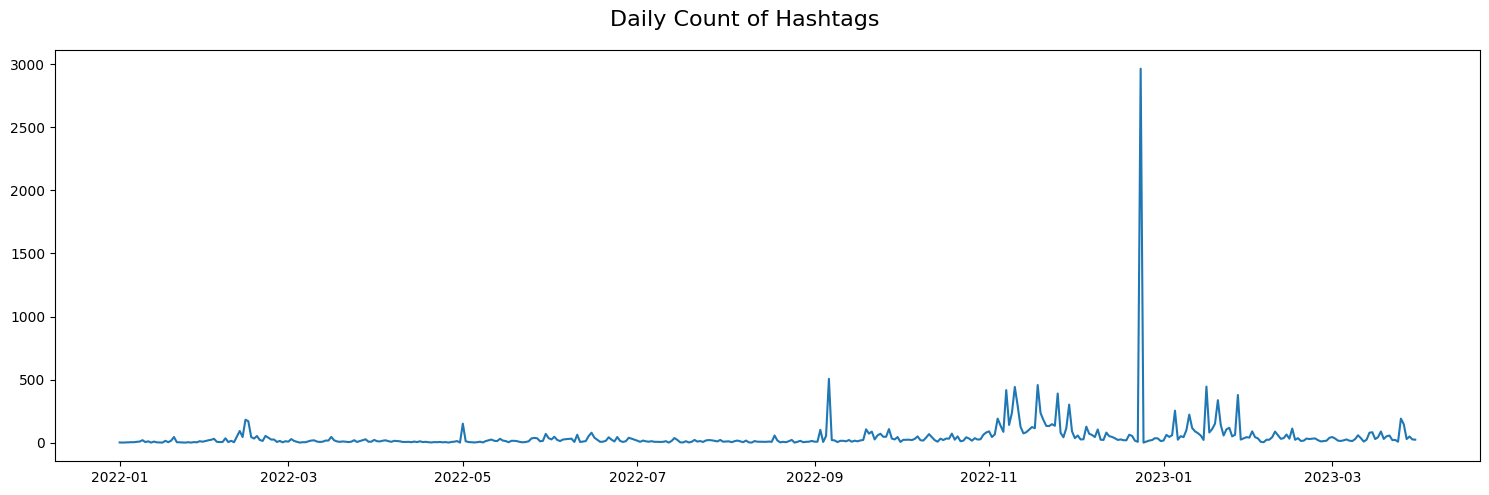

In [41]:
generatePlot('Daily Count of Hashtags', twh_hashtags_per_day_df, 'count')

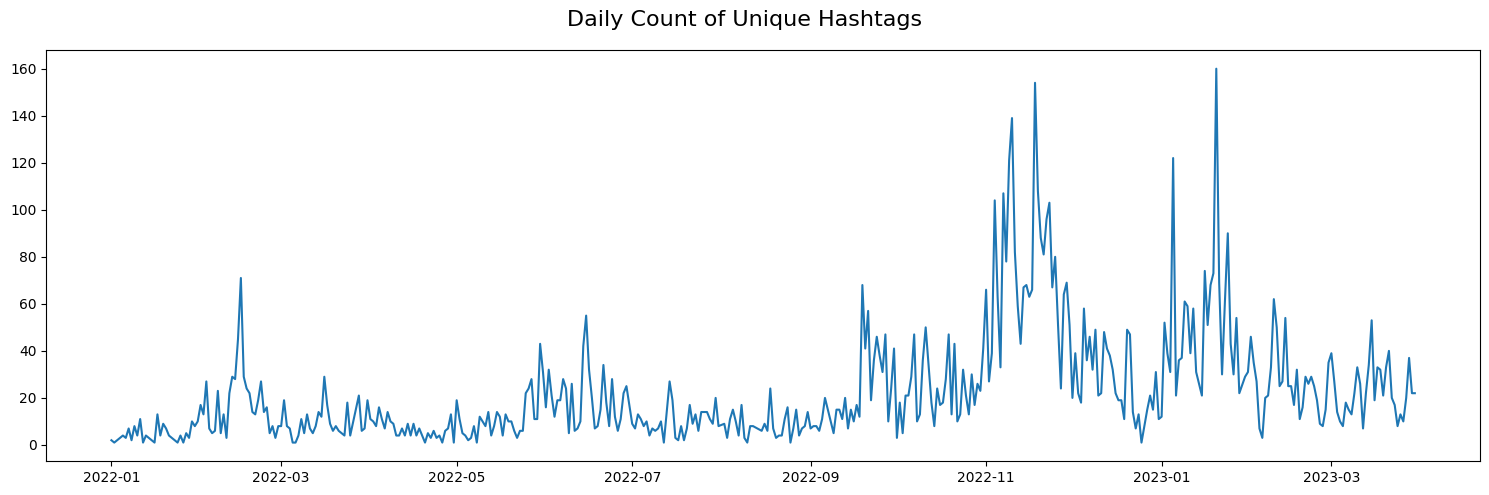

In [42]:
generatePlot('Daily Count of Unique Hashtags', twh_hashtags_per_day_df, 'unique_count')

#### Daily Users Count

In [43]:
def generateUsers(df, groupedby, data, DATES=DATES):
    grouped = df.groupby([df[groupedby].dt.year, df[groupedby].dt.month, df[groupedby].dt.day])[data].apply(list)
    
    count = [len(day) for day in grouped]
    unique = [len(set(day)) for day in grouped]
    df = pd.DataFrame([DATES, count, unique]).T
    df.rename(columns = {0: 'date', 1: 'count', 2: 'unique_count'}, inplace=True)
    df.set_index('date', drop=True, inplace=True)
    
    return df

##### Initial Data

In [44]:
# id_users_per_day_df = generateUsers(idata, 'created_at', 'users.username')
# id_users_per_day_df.head()

##### Non Duplicate Data

In [45]:
# nd_users_per_day_df = generateUsers(nddata, 'created_at', 'users.username')
# nd_users_per_day_df.head()

##### Tweets with Hashtags

In [46]:
twh_users_per_day_df = generateUsers(tweets_hashtags, 'created_at', 'users.username', DATES=DATES_NEW)

In [47]:
# generateTwoPlots('Daily Count of Unique Users', id_users_per_day_df, nd_users_per_day_df, 'unique_count', 'initial tweets', 'non duplicate tweets')

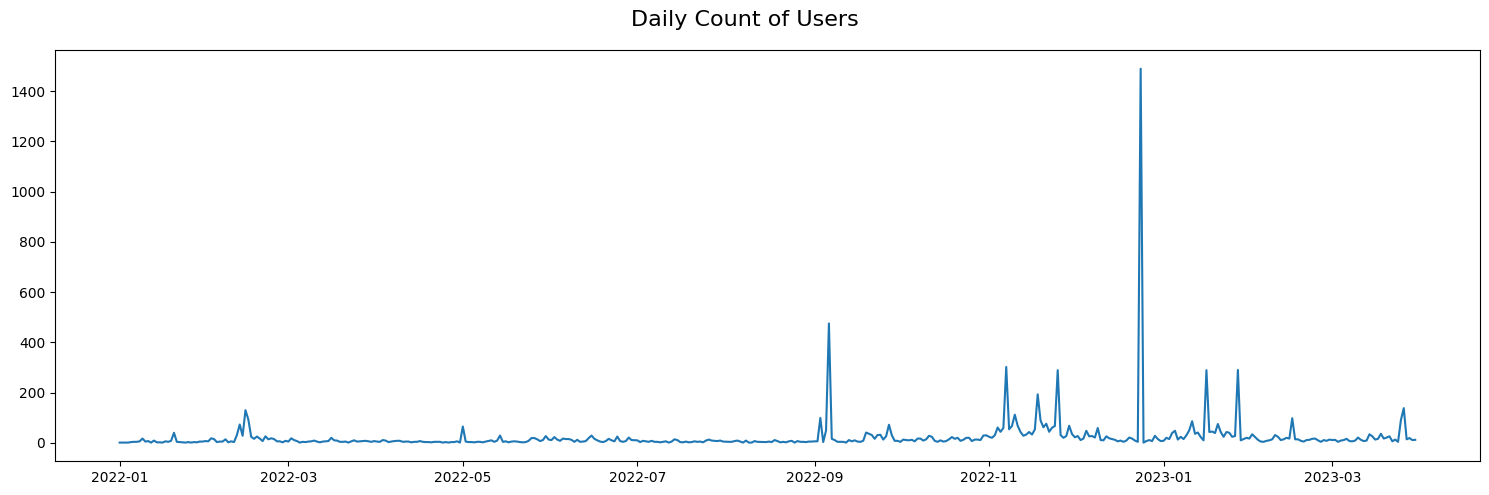

In [48]:
generatePlot('Daily Count of Users', twh_users_per_day_df, 'count')

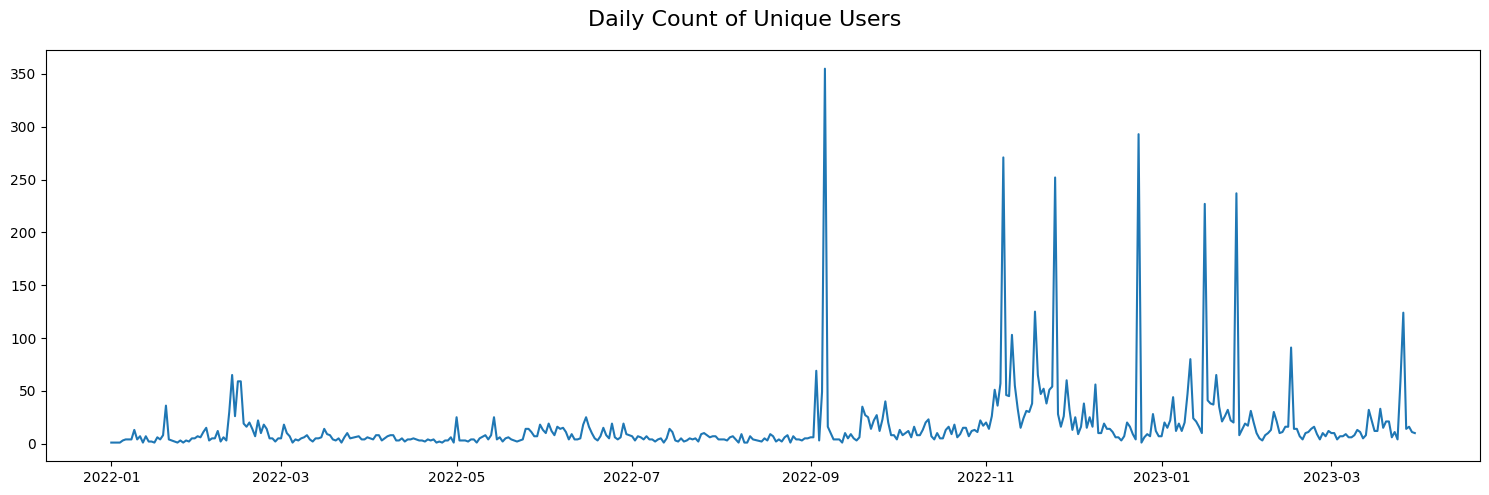

In [49]:
generatePlot('Daily Count of Unique Users', twh_users_per_day_df, 'unique_count')

#### Daily Tweets Count

In [50]:
def generateTweets(df, groupedby, data, DATES=DATES):
    grouped = df.groupby([df[groupedby].dt.year, df[groupedby].dt.month, df[groupedby].dt.day])[data].count()
    
    count = [day for day in grouped]
    
    df = pd.DataFrame([DATES, count]).T
    df.rename(columns = {0: 'date', 1: 'count'}, inplace=True)
    df.set_index('date', drop=True, inplace=True)
    
    return df

##### Initial Data

In [51]:
# id_tweets_per_day_df = generateTweets(idata, 'created_at', 'text')
# id_tweets_per_day_df.head()

##### Non Duplicate Data

In [52]:
# nd_tweets_per_day_df = generateTweets(nddata, 'created_at', 'text')
# nd_tweets_per_day_df.head()

##### Tweets with Hashtags

In [53]:
twh_tweets_per_day_df = generateTweets(tweets_hashtags, 'created_at', 'text', DATES=DATES_NEW)

In [54]:
# generateTwoPlots('Daily Count of Tweets', id_tweets_per_day_df, nd_tweets_per_day_df, 'count', 'initial tweets', 'non duplicate tweets')

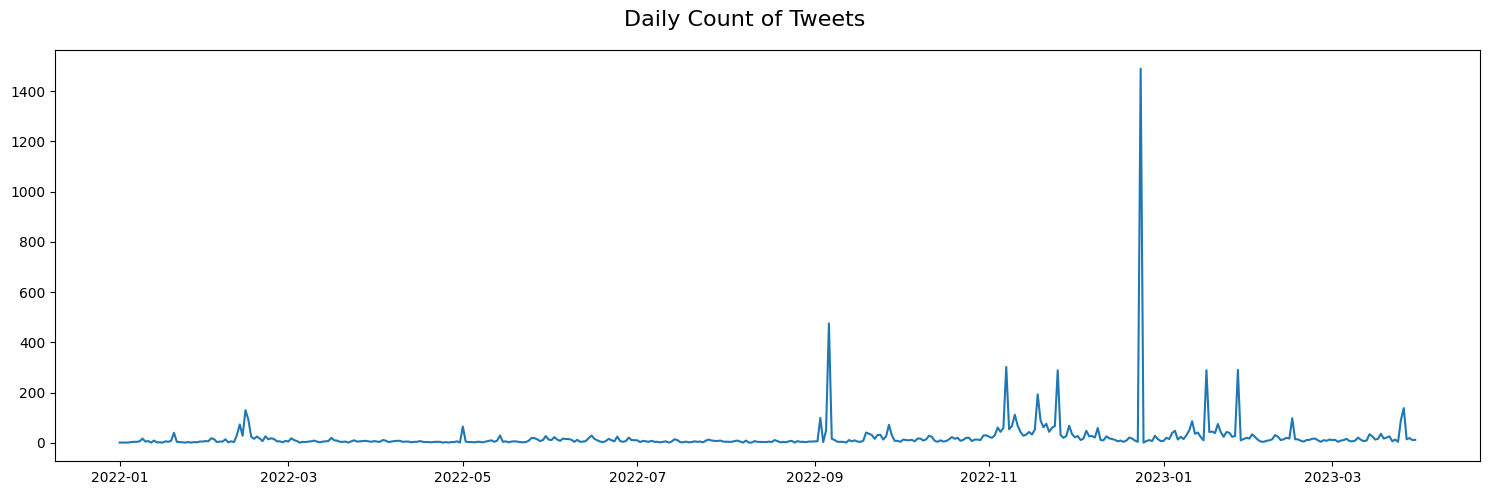

In [55]:
generatePlot('Daily Count of Tweets', twh_tweets_per_day_df, 'count')

#### Ratio of Unique Users that Use Unique Hashtags Daily

In [56]:
def generateRatio(df1, df2, column1, column2, DATES=DATES):
    
    ratio = df1[column1]/df2[column2]
    df = pd.DataFrame([DATES, list(ratio)]).T
    df.rename(columns = {0: 'date', 1: 'ratio'}, inplace=True)
    df.set_index('date', drop=True, inplace=True)
    
    return df

##### Initial Data

In [57]:
# idratio_users_hashtags_df = generateRatio(id_hashtags_per_day_df, id_users_per_day_df, 'unique_count', 'unique_count')
# idratio_users_hashtags_df.head(2)

##### Non Duplicate Data

In [58]:
# ndratio_users_hashtags_df = generateRatio(nd_hashtags_per_day_df, nd_users_per_day_df, 'unique_count', 'unique_count')
# ndratio_users_hashtags_df.head(2)

##### Tweets with Hashtags

In [59]:
twhratio_users_hashtags_df = generateRatio(twh_users_per_day_df, twh_hashtags_per_day_df, 'unique_count', 'count', DATES_NEW)

In [60]:
# generateTwoPlots('Ratio of Unique Users that Use Unique Hashtags Daily', idratio_users_hashtags_df, ndratio_users_hashtags_df, 'ratio', 'initial tweets', 'non duplicate tweets')

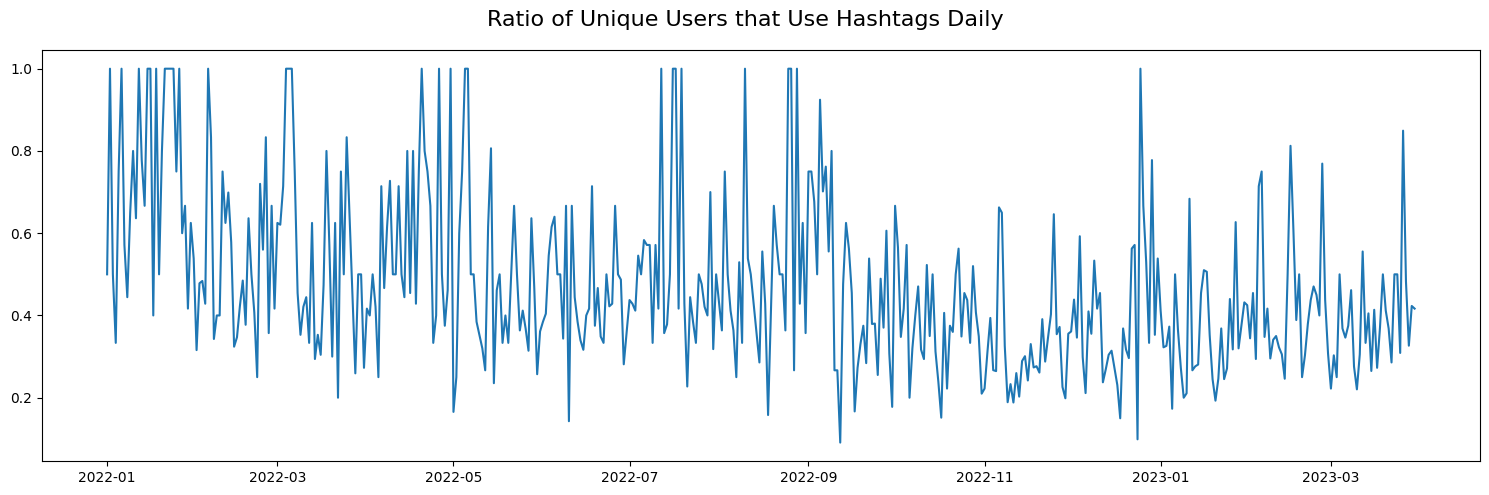

In [61]:
generatePlot('Ratio of Unique Users that Use Hashtags Daily', twhratio_users_hashtags_df, 'ratio')

#### Ratio of Tweets that Have Hashtags

##### Initial Data

In [62]:
# idratio_tweets_hashtags_df = generateRatio(id_hashtags_per_day_df, id_tweets_per_day_df, 'unique_count', 'count')
# idratio_tweets_hashtags_df.head(2)

##### Non Duplicate Data

In [63]:
# ndratio_tweets_hashtags_df = generateRatio(nd_hashtags_per_day_df, nd_tweets_per_day_df, 'unique_count', 'count')
# ndratio_tweets_hashtags_df.head(2)

##### Tweets with Hashtags

In [64]:
twhratio_tweets_hashtags_df = generateRatio(twh_tweets_per_day_df, twh_hashtags_per_day_df, 'count', 'count', DATES=DATES_NEW)

In [65]:
# generateTwoPlots('Ratio of Tweets that Have Hashtags', idratio_tweets_hashtags_df, ndratio_tweets_hashtags_df, 'ratio', 'initial tweets', 'non duplicate tweets')

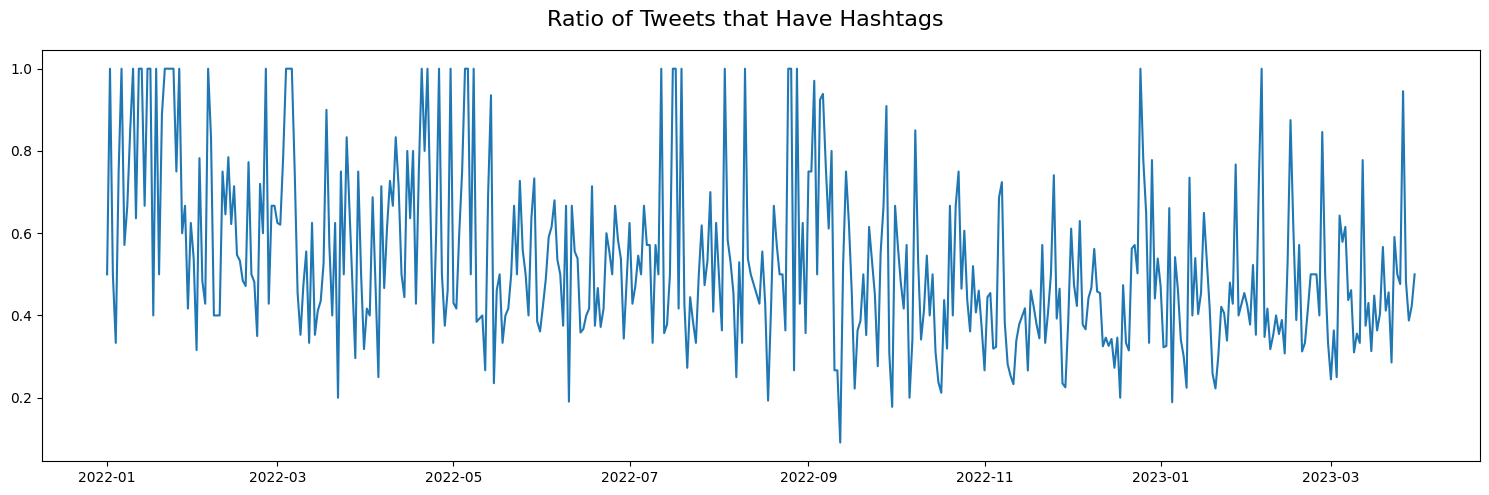

In [66]:
generatePlot('Ratio of Tweets that Have Hashtags', twhratio_tweets_hashtags_df, 'ratio')

#### Word Clouds of Hashtags

In [67]:
wch_lists = []
for hashtag in tweets_hashtags['hashtags']:
    if hashtag is not np.nan:
        for item in hashtag:
            wch_lists.append(item)

In [68]:
word_cloud_hashtags = WordCloud(width = 1000, height = 500, collocations = False, background_color = 'white').generate(" ".join(wch_lists))

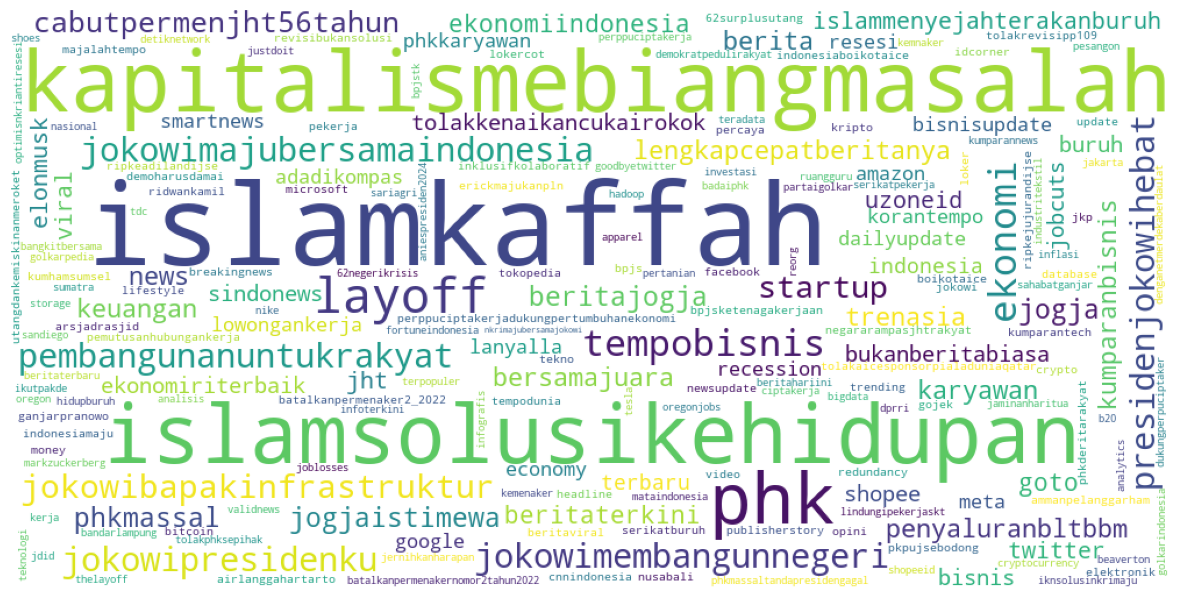

In [69]:
plt.figure(figsize=(15,8))
plt.imshow(word_cloud_hashtags)
plt.axis("off")
plt.show()

#### Word Clouds of Tweets

In [70]:
wct_lists = [tweet for tweet in stemmed_data['text'] if tweet is not np.nan]

In [71]:
word_cloud_tweets = WordCloud(width = 1000, height = 500, collocations = False, background_color = 'white').generate(" ".join(wct_lists))

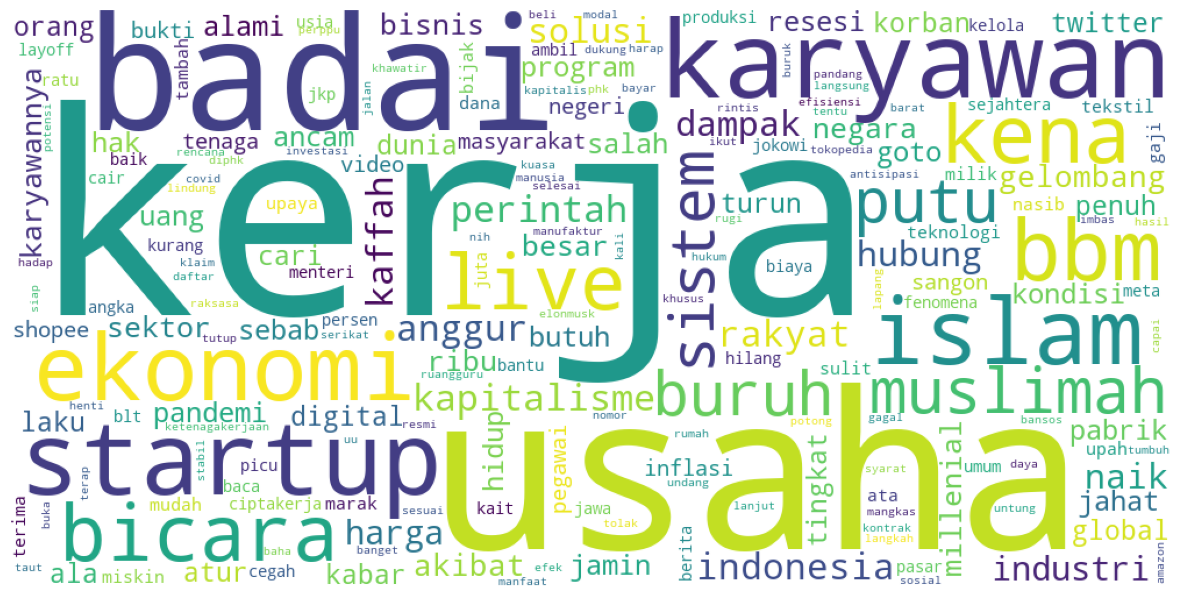

In [72]:
plt.figure(figsize=(15,8))
plt.imshow(word_cloud_tweets)
plt.axis("off")
plt.show()